<a href="https://colab.research.google.com/github/jmq19950824/Machine-Learning-with-Python/blob/master/VGG16_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
import time
import numpy as np
from torch.utils.data import Dataset,DataLoader

In [0]:
vgg=models.vgg16(pretrained=True).cuda()

if torch.cuda.is_available():
  is_cuda=True

for param in vgg.features.parameters():
  param.requires_grad=False

vgg.classifier[6].out_features=2

Data

In [0]:
#Data augmentation
aug_transform=transforms.Compose([transforms.Resize((224,224)),
                 transforms.RandomHorizontalFlip(),
                 transforms.RandomRotation(0.2),
                 transforms.ToTensor(),
                 transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
simple_transform=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),
                  transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
train=ImageFolder('../content/drive/My Drive/Book Codes/PyTorch深度学习/dogsandcats/train/',aug_transform)
valid=ImageFolder('../content/drive/My Drive/Book Codes/PyTorch深度学习/dogsandcats/valid/',simple_transform)

In [0]:
simple_transform=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),
                  transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
train=ImageFolder('../content/drive/My Drive/Book Codes/PyTorch深度学习/dogsandcats/train/',simple_transform)
valid=ImageFolder('../content/drive/My Drive/Book Codes/PyTorch深度学习/dogsandcats/valid/',simple_transform)

In [0]:
def preconvfeat(dataset,model):
  conv_features=[]
  labels_list=[]

  for data in dataset:
    inputs,labels=data

    if is_cuda:
      inputs,labels=inputs.cuda(),labels.cuda()
    
    inputs,labels=Variable(inputs),Variable(labels)
    output=model(inputs)

    conv_features.extend(output.data.cpu().numpy())
    labels_list.extend(labels.data.cpu().numpy())

  conv_features=np.concatenate([[feat] for feat in conv_features])
  return(conv_features,labels_list)

In [0]:
class My_dataset(Dataset):
    def __init__(self,feat,labels):
        self.conv_feat = feat
        self.labels = labels
    
    def __len__(self):
        return len(self.conv_feat)
    
    def __getitem__(self,idx):
        return self.conv_feat[idx],self.labels[idx]

In [0]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=32,num_workers=8,shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(valid,batch_size=32,num_workers=8,shuffle=True)

conv_feat_train,labels_train=preconvfeat(train_data_loader,vgg.features)
conv_feat_val,labels_val=preconvfeat(valid_data_loader,vgg.features)

train_feat_dataset=My_dataset(conv_feat_train,labels_train)
val_feat_dataset=My_dataset(conv_feat_val,labels_val)

train_feat_loader=DataLoader(train_feat_dataset,batch_size=32,shuffle=True)
val_feat_loader=DataLoader(val_feat_dataset,batch_size=32,shuffle=True)

def data_gen(conv_feat,labels,batch_size=64,shuffle=True):
  labels = np.array(labels)
  if shuffle:
      index = np.random.permutation(len(conv_feat))
      conv_feat = conv_feat[index]
      labels = labels[index]
  for idx in range(0,len(conv_feat),batch_size):
      yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size])

train_batches = data_gen(conv_feat_train,labels_train)
val_batches = data_gen(conv_feat_val,labels_val)

In [0]:
optimizer=optim.SGD(vgg.classifier.parameters(),lr=0.0001,momentum=0.5)

In [0]:
def fit_numpy(model,data_loader,phase='training',volatile=False):
  
  running_loss=0.0
  running_acc=0

  if phase=='training':
    model.train()
  if phase=='validation':
    model.eval()
    volatile=True

  for batch_idx,(data,target) in enumerate(data_loader):
    if is_cuda:
      data,target=data.cuda(),target.cuda()
    data,target=Variable(data,volatile),Variable(target)

    if phase=='training':
      optimizer.zero_grad()
    ###
    data=data.view(data.size(0),-1)
    ###
    output=model(data)
    loss=F.cross_entropy(output,target)
    preds=output.data.max(dim=1,keepdim=True)[1]
    #What is the difference between nll_loss and cross_entropy?
    running_loss+=F.cross_entropy(output,target,size_average=False).data
    running_acc+=preds.eq(target.data.view_as(preds)).cpu().sum()

    if phase=='training':
      loss.backward()
      optimizer.step()
  
  loss=running_loss/len(data_loader.dataset)
  acc=100.*running_acc/len(data_loader.dataset)

  print(f'loss in {phase}:{loss};acc in {phase}:{acc}')
  return loss,acc

In [0]:
for layer in vgg.classifier.children():
  if(type(layer)==nn.Dropout):
    layer.p=0.5

In [0]:
import time
time_start=time.time()

train_loss,train_acc=[],[]
val_loss,val_acc=[],[]
for epoch in range(1,10):
  train_epoch_loss,train_epoch_acc=fit_numpy(vgg.classifier,train_feat_loader,phase='training')
  val_epoch_loss,val_epoch_acc=fit_numpy(vgg.classifier,val_feat_loader,phase='validation')
  
  train_loss.append(train_epoch_loss)
  train_acc.append(train_epoch_acc)
  val_loss.append(val_epoch_loss)
  val_acc.append(val_epoch_acc)

time_end=time.time()
print(f'Running Time:{time_end-time_start}')

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


loss in training:0.0661008358001709;acc in training:97.75499725341797
loss in validation:0.04890551418066025;acc in validation:98.36000061035156
loss in training:0.06315156817436218;acc in training:97.86499786376953
loss in validation:0.046605102717876434;acc in validation:98.4000015258789
loss in training:0.059944357722997665;acc in training:98.06500244140625
loss in validation:0.04521862044930458;acc in validation:98.4800033569336
loss in training:0.0589471161365509;acc in training:98.05999755859375
loss in validation:0.044132716953754425;acc in validation:98.4800033569336
loss in training:0.05381400138139725;acc in training:98.1449966430664
loss in validation:0.04320521280169487;acc in validation:98.5
loss in training:0.04991331696510315;acc in training:98.28500366210938
loss in validation:0.04266958683729172;acc in validation:98.54000091552734
loss in training:0.052200254052877426;acc in training:98.2300033569336
loss in validation:0.041878651827573776;acc in validation:98.55999755

In [0]:
train_05_noaug=train_acc
val_05_noaug=val_acc

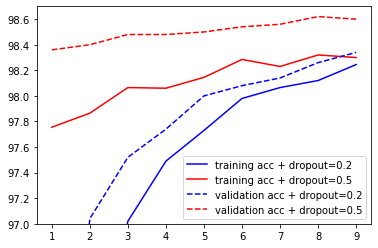

In [0]:
import matplotlib.pyplot as plt
plt.plot(range(1,10),train_02_noaug,'b',label='training acc + dropout=0.2')
plt.plot(range(1,10),train_05_noaug,'r',label='training acc + dropout=0.5')

plt.plot(range(1,10),val_02_noaug,'--b',label='validation acc + dropout=0.2')
plt.plot(range(1,10),val_05_noaug,'--r',label='validation acc + dropout=0.5')
plt.ylim(97,98.7)
plt.legend()